# **Logistic Regression**


In [ ]:
#importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader #train ve test dataları pytorch'ta kullanılabilir hale getirilmek için DataLoader methodu kullanılır.

In [ ]:
train = pd.read_csv(r"C:\Users\ŞEVVAL\Desktop\train.csv",dtype = np.float32)
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Datadaki görseller 28x28 boyutundadır ve 0-9 arası 10 class bulunur.

In [ ]:
targets_numpy = train.label.values
features_numpy = (train.loc[:,train.columns != "label"].values)/255 #normalization

values methodu ile label pandas series'ten numpy array'e çevrilir.

Algoritmanın daha hızlı çalışması için rgb formatındaki pikseller 255'e bölünerek 0-1 aralığına çekilir.

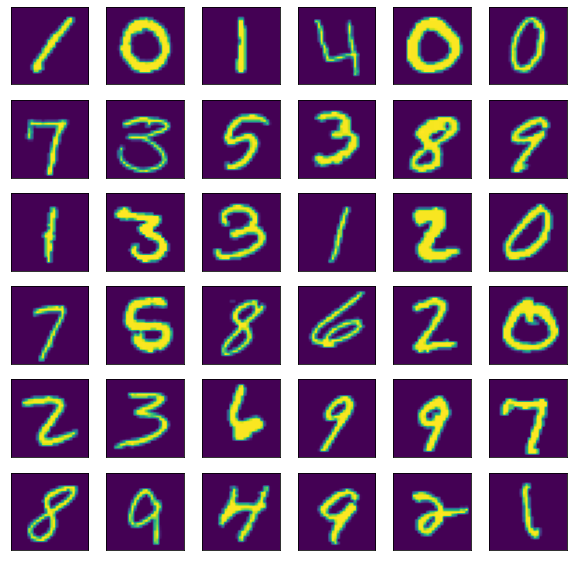

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = [features_numpy[i]]
    img = np.reshape(img, (28, 28))
    plt.imshow(img)
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42)

In [ ]:
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor)

In [ ]:
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor)

Numpy array'ler pytorch kütüphanesinde kullanılabilmek için tensor'e dönüştürülür.

In [ ]:
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size) #(10000/(36000/100)) = 29 -> epoch
num_epochs = int(num_epochs) #29 epoch

**batch size verinin kaça bölünerek train edileceğidir.**

Eğer data 1000 sample'dan oluşuyorsa batch size 100 olarak belirlendiğinde, data 100'er sample'dan oluşan 10 gruba ayrılır.

**Epoch train datası kullanılarak kaç defa training işleminin gerçekleştirileceğidir.**

Datada 33600 sample bulunmaktadır. batch size 100, epoch 29 olarak belirlenmiştir.

Bu durumda (33600)/(100) = 336 grup oluşacaktır.

Bir epoch 336 training işlemi gerçekleşeceğinden, bir epoch 336 iteration'dan oluşur.

Bu durumda 29 epoch'ta 9744 iteration bulunur, yaklaşık 10000 denilebilir.

In [ ]:
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

Dataset tensorlerle sarılır. Her sample ilk boyut boyunca tensörlerin indekslenmesiyle alınır. 

In [ ]:
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

DataLoader methoduyla dataset ve samplelar batch size'a göre combine edilir.

In [ ]:
#Create Logistic Regression Model
class LogisticRegressionModel(nn.Module): 
    def __init__(self, input_dim, output_dim): #logistic regression modelinde input size ve output size bilinmelidir.
        super(LogisticRegressionModel, self).__init__() #neural network modülünden Logistic Regression parametreleri inherit edilir
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x):
        out = self.linear(x) 
        return out #logistic regression modeli x adında bir input parametresi alır ve y -> output döndürür.

In [ ]:
input_dim = 28*28 #görseller 28x28 boyutunda olduğundan input size 28*28 olarak verilir.
output_dim = 10  #0-9 arası 10 class bulunmaktadır.

In [ ]:
model = LogisticRegressionModel(input_dim, output_dim) #logistic regression modeli yaratılır.

In [ ]:
error = nn.CrossEntropyLoss() #loss function'ın hesaplanması için CrossEntropyLoss methodu kullanılacaktır. 

In [ ]:
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

parametreleri güncellemek için Stochastic Gradient Descent yöntemi kullanılmıştır.

In [ ]:
#Traning the Model
count = 0
loss_list = []
iteration_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        #Define variables
        train = Variable(images.view(-1, 28*28))
        #reshape'in pytorch'taki karşılığı view methodudur.
        #view methoduyla flatten yapılarak (1,784) boyutunda bir vektör elde edilir.
        labels = Variable(labels)
        #gradientleri handle edebilmek için variable yapısı kullanılır.
        
        #Clear gradients
        optimizer.zero_grad() #optimizer içerisinde güncellenecek parametreler bulunmaktadır.
                              #başlangıçta parametre değerleri 0 olarak belirlenir.
        
        #Forward propagation
        outputs = model(train) #logistic regression modeline train datası yollanarak forward propagation ile outputlar elde edilir.
        
        #Calculate softmax and cross entropy loss
        loss = error(outputs, labels) 
        #CrossEntropyLoss methodu içerisinde softmax activation function hesaplanır.
        #softmax function'dan elde edilen y_head değerleri ile label'lar arasındaki loss hesaplanır.
        
        # alculate gradients
        loss.backward()
        #loss'un parametrelere göre türevi alınarak, parametrelerin ne kadar güncelleneceği bulunur.
        
        #Update parameters
        optimizer.step()
        #parametreler güncellenir.
        
        count += 1
        
        #Prediction
        if count % 50 == 0: #count 50 ve 50'nin katları olduğu sürece prediction işlemi gerçekleştirilir.
            
            #Calculate Accuracy         
            correct = 0 #doğtu tahmin edilenler
            total = 0 #tahmin edilenlerin tümü
            
            #Predict test dataset
            for images, labels in test_loader: 
                test = Variable(images.view(-1, 28*28))
                #test isimli bir variable'a image'ler eşitlenir.
                
                #Forward propagation
                outputs = model(test)
                #0-9 arası classlardan prediction işlemi gerçekleştirilir.
                #probabilistic bir sonuç ortaya çıkar.
                
                #Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                #probabilistic değerlerden en olası olana (1'e en yakın olana) bakılır.
                
                #Total number of labels
                total += len(labels)
                #test datasında kaç sample olduğuna bakılır.
                
                #Total correct predictions
                correct += (predicted == labels).sum()
                #predicted ile total aynı ise doğru tahmindir, correct isimli variable'a eklenir.
            
            accuracy = 100 * (correct / float(total))
            
            #store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            
        if count % 500 == 0: #count 500'ün katı oldukça accuracy ve loss değerleri yazdırılır.
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {}%'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 1.8154857158660889  Accuracy: 66.63095092773438%
Iteration: 1000  Loss: 1.60993230342865  Accuracy: 75.41666412353516%
Iteration: 1500  Loss: 1.310237169265747  Accuracy: 78.6547622680664%
Iteration: 2000  Loss: 1.193172812461853  Accuracy: 80.4047622680664%
Iteration: 2500  Loss: 1.0256983041763306  Accuracy: 81.75%
Iteration: 3000  Loss: 0.9504697322845459  Accuracy: 82.41666412353516%
Iteration: 3500  Loss: 0.8969907164573669  Accuracy: 83.05952453613281%
Iteration: 4000  Loss: 0.7586400508880615  Accuracy: 83.54762268066406%
Iteration: 4500  Loss: 0.9784201979637146  Accuracy: 83.96428680419922%
Iteration: 5000  Loss: 0.8080844283103943  Accuracy: 84.28571319580078%
Iteration: 5500  Loss: 0.7461640238761902  Accuracy: 84.57142639160156%
Iteration: 6000  Loss: 0.8728743195533752  Accuracy: 84.82142639160156%
Iteration: 6500  Loss: 0.6666674613952637  Accuracy: 85.04762268066406%
Iteration: 7000  Loss: 0.7143778204917908  Accuracy: 85.23809051513672%
Iteration: 

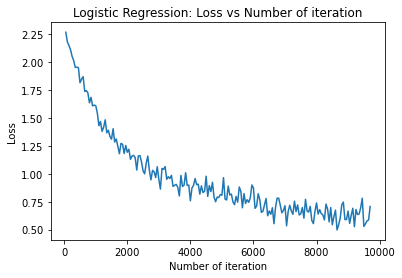

In [ ]:
#visualizing
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Logistic Regression: Loss vs Number of iteration")
plt.show()